# Sentinel 2 cloud free best pixel WF

remove cloud and shadow from series of S2 ARD images

then mosaic them to create a best pixel image for given time period

# steps:

Run a pyeodh stac search for given time period


In [2]:
import pyeodh
import xarray as xr
import rioxarray

# pyeodh.set_log_level(10)
rc = pyeodh.Client().get_catalog_service()

thetford_pnt = {
    "coordinates": [
        [
            [0.08905898091569497, 52.69722175598818],
            [0.08905898091569497, 52.15527412683906],
            [0.9565339502005088, 52.15527412683906],
            [0.9565339502005088, 52.69722175598818],
            [0.08905898091569497, 52.69722175598818],
        ]
    ],
    "type": "Polygon",
}

items = rc.search(
    collections=["sentinel2_ard"],
    catalog_paths=["supported-datasets/ceda-stac-fastapi"],
    intersects=thetford_pnt,
    query=[
        "start_datetime>=2023-04-01",
        "end_datetime<=2023-06-30",
    ],
    limit=10,
)



For each item open `cog`, `cloud` and `valid` .tif assets and remove the cloud like this:


In [3]:
for item in items.get_limited()[0:1]:
    cloud_href = item.assets["cloud"].href
    valid_href = item.assets["valid_pixels"].href
    cog_href = item.assets["cog"].href
    print(item.id, cloud_href, valid_href, cog_href, sep="\n")
    valid = rioxarray.open_rasterio(valid_href)
    cloud = rioxarray.open_rasterio(cloud_href)
    cog = rioxarray.open_rasterio(cog_href)
    print("==" * 10)
    print("success")
    break
    


neodc.sentinel_ard.data.sentinel_2.2023.06.25.S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb
https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/25/S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb_clouds.tif
https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/25/S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb_valid.tif
https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/25/S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif
success


In [13]:
result = valid + cloud

In [14]:
# Set values greater than 1 to 0, others remain as 1
result = xr.where(result > 1, 0, 1)

In [21]:
# Multiply cog.tif by the result

# res_list = []
# for i in cog.band.values[:2]:
    # res_list.append(cog.isel(band=i) * result)
# final_result = xr.concat(res_list, dim="band")

# b0 = cog.isel(band=0) * result
b5 = cog.isel(band=5) * result



In [25]:
result


<xarray.DataArray (band: 1, y: 11131, x: 11131)> Size: 991MB
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 89kB 4.318e+05 4.318e+05 ... 5.431e+05 5.431e+05
  * y            (y) float64 89kB 3.716e+05 3.716e+05 ... 2.603e+05 2.603e+05
    spatial_ref  int64 8B 0

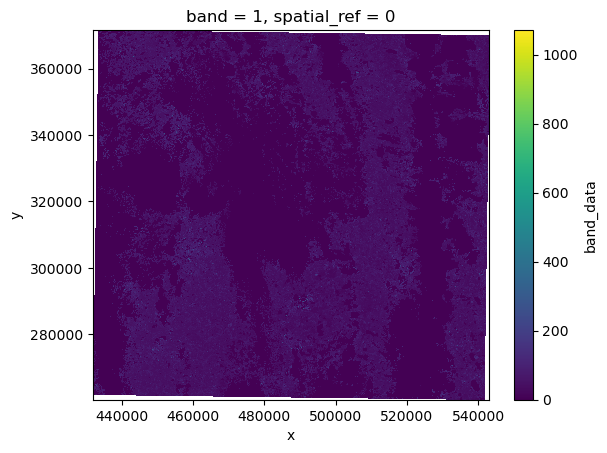

In [7]:
final_result.squeeze().plot.imshow()
